# Imports

In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv('../data/Megans_List.csv')

In [3]:
df.fillna('no info', inplace=True)

# EDA

Looking at mostly empty fields

In [4]:
sparse_cols = [u'Score', u'Score Date', u'Tool Name', u'Year of Last Conviction', u'Year of Last Release']

for column in sparse_cols:
    print column
    null = df[column].unique()[0]
    print 'Missing: ', (df[column] == null).sum()
    print 'Present: ', (df[column] != null).sum()

Score
Missing:  38437
Present:  11009
Score Date
Missing:  38437
Present:  11009
Tool Name
Missing:  38437
Present:  11009
Year of Last Conviction
Missing:  45526
Present:  3920
Year of Last Release
Missing:  45526
Present:  3920


In [5]:
good_red = ['redtext{}'.format(num) for num in xrange(3)]
for red in good_red:
    print red
    print df[red].unique()
    print 'Blanks: ', (df[red] == u'').sum()
    if red == 'redtext1':
        print 'Others: ', df[red].count() -(df[red] == u'').sum() - df[red].str.contains('VIOLATION').sum()

redtext0
['no info' 'Specific address not subject to disclosure' 'TRANSIENT'
 'WHEREABOUTS UNKNOWN']
Blanks:  0
redtext1
['no info'
 'THIS SEX OFFENDER HAS BEEN IN VIOLATION OF REGISTRATION REQUIREMENTS SINCE 02/22/2006.'
 'THIS SEX OFFENDER HAS BEEN IN VIOLATION OF REGISTRATION REQUIREMENTS SINCE 04/27/2015.'
 ...,
 'THIS SEX OFFENDER HAS BEEN IN VIOLATION OF REGISTRATION REQUIREMENTS SINCE 12/03/2006.'
 'THIS SEX OFFENDER HAS BEEN IN VIOLATION OF REGISTRATION REQUIREMENTS SINCE 11/08/1996.'
 'THIS SEX OFFENDER HAS BEEN IN VIOLATION OF REGISTRATION REQUIREMENTS SINCE 03/03/2001.']
Blanks:  0
Others:  40501
redtext2
[ 'DOJ is unable to determine if there are any subsequent felony convictions for this registrant at this time.'
 'Registrant has subsequent felony conviction(s) but DOJ has no incarceration information for this felony.'
 'Registrant has no California subsequent felony convictions.'
 'Registrant was incarcerated for a subsequent felony conviction(s).']
Blanks:  0


In [71]:
df.head()

,Description,Offense Code,Score,Score Date,Tool Name,Year of Last Conviction,Year of Last Release,redtext0,redtext1,redtext2,...,AMERICAN INDIAN,ASIAN INDIAN,SAMOAN,HAWAIIAN,CAMBODIAN,JAPANESE,LAOTIAN,County,Num Score,Score missing
0,"[INDECENT EXPOSURE, ASSAULT WITH INTENT TO COM...","[314.1, 220, 243.4(a)]",no info,no info,no info,,,no info,no info,DOJ is unable to determine if there are any su...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMEDA,2,1
1,"[RAPE BY FORCE OR FEAR, ORAL COPULATION WITH A...","[261(a)(2), 288a(c)]",no info,no info,no info,,,no info,no info,DOJ is unable to determine if there are any su...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMEDA,2,1
2,"[PRIOR CODE: ANNOY OR MOLEST A CHILD, PRIOR CO...","[647a(1), 288, 288(a)]",no info,no info,no info,,,no info,THIS SEX OFFENDER HAS BEEN IN VIOLATION OF REG...,DOJ is unable to determine if there are any su...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,2,1
3,[CONTINUOUS SEXUAL ABUSE OF CHILD],[288.5(a)],no info,no info,no info,,,no info,no info,DOJ is unable to determine if there are any su...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMEDA,2,1
4,[LEWD OR LASCIVIOUS ACTS WITH A CHILD UNDER 14...,[288(a)],no info,no info,no info,,,no info,no info,Registrant has subsequent felony conviction(s)...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMEDA,2,1


In [7]:
df.columns

Index([u'Description', u'Offense Code', u'Score', u'Score Date', u'Tool Name',
       u'Year of Last Conviction', u'Year of Last Release', u'redtext0',
       u'redtext1', u'redtext2', u'so_id', u'Date of Birth', u'Ethnicity',
       u'Eye Color', u'Hair Color', u'Height', u'Last Known Address', u'Sex',
       u'Weight'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49446 entries, 0 to 49445
Data columns (total 19 columns):
Description                49446 non-null object
Offense Code               49446 non-null object
Score                      49446 non-null object
Score Date                 49446 non-null object
Tool Name                  49446 non-null object
Year of Last Conviction    49446 non-null object
Year of Last Release       49446 non-null object
redtext0                   49446 non-null object
redtext1                   49446 non-null object
redtext2                   49446 non-null object
so_id                      49446 non-null object
Date of Birth              49446 non-null object
Ethnicity                  49446 non-null object
Eye Color                  49446 non-null object
Hair Color                 49446 non-null object
Height                     49446 non-null object
Last Known Address         49446 non-null object
Sex                        49446 non-null object
Weight   

# Feature Engineering

In [9]:
code_sentencing = {}
with open('../data/code_sentencing.txt') as f:
    for line in f:
        if 'skip' in line:
            continue
        code = line.split(':')[0]
        sentences = set(float(sentence.strip()) for sentence in line.split(':')[1].split(','))
        code_sentencing[code] = sentences

In [10]:
df['Description'] = df['Description'].apply(lambda x: x.split(';'))
df['Offense Code'] = df['Offense Code'].apply(lambda x: x.split(';'))
df['Number of Offenses'] = df['Offense Code'].apply(lambda x: len(x))
df['Priors'] = df['Description'].apply(lambda x: sum(1 if 'PRIOR' in y else 0 for y in x))
df['Height in Inches'] = df['Height'].apply(lambda x: int(x.split("'")[0]) * 12 + int(x.split("'")[1].strip('"')))
df['BMI'] = df['Weight'] * 0.45 / (df['Height in Inches'] * 0.025) ** 2
df['Female'] = pd.get_dummies(df['Sex'])['FEMALE']
df['Violation'] = df['redtext1'].str.contains('VIOLATION') * 1
df['Transient'] = df['redtext0'].str.contains('TRANSIENT') * 1
df['Age'] = 2016 - df['Date of Birth'].apply(lambda x: int(x.split('-')[-1]))
df['Years in Violation'] = df['redtext1'].apply(lambda x: 2016 - int(x.split('/')[-1]
                                                .split('.')[0]) if 'VIOLATION' in x else 0)
df['SVP'] = df['redtext1'].str.contains('VIOLENT') * 1
df['Age in Question'] = df['Age'] - df['Years in Violation']
df['Possible Sentences'] = df['Offense Code'].apply(lambda lst: set.union(set(), 
                                                    *[code_sentencing[code] 
                                                    for code in lst if code in code_sentencing]))
df['Minimum Sentence'] = df['Possible Sentences'].apply(lambda x: min(x) if len(x) > 0 else 0.0)
df['Maximum Sentence'] = df['Possible Sentences'].apply(lambda x: max(x) if len(x) > 0 else 0.0)

# More EDA

Height in Inches


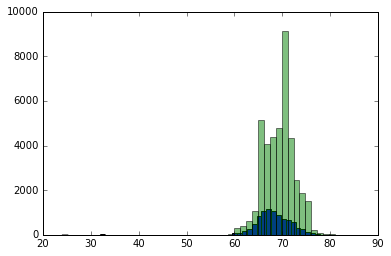

BMI


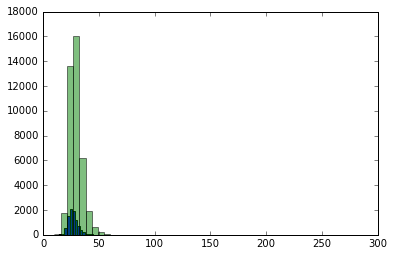

Female


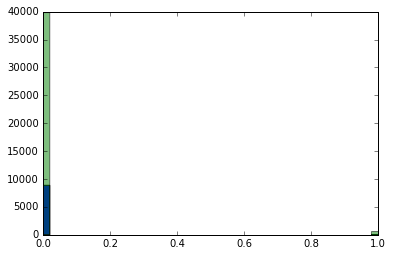

Violation


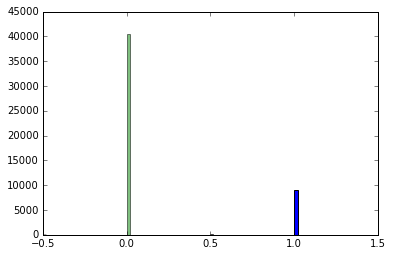

Transient


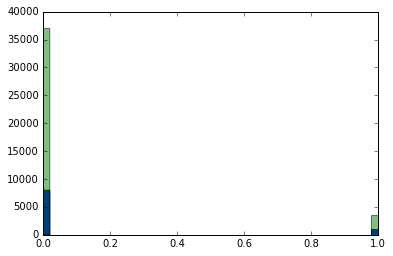

Age


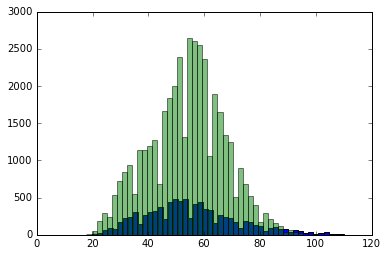

Years in Violation


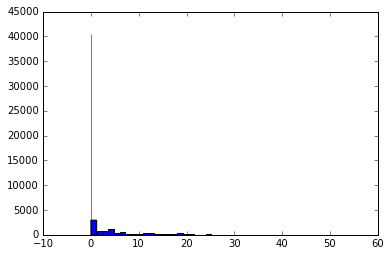

SVP


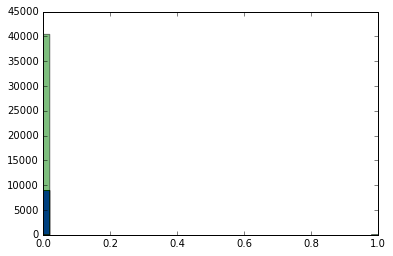

Age in Question


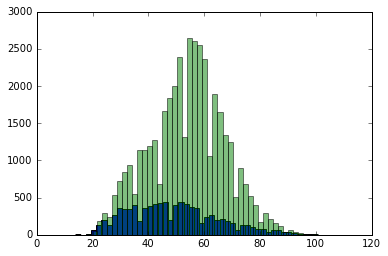

Possible Sentences


TypeError: len() of unsized object

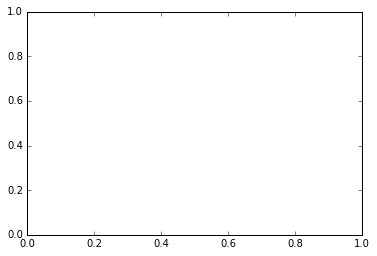

In [12]:
for column in df.columns[-12:]:
    print column
    plt.figure()
    plt.hist(df[df['Violation'] == 1][column], bins=50)
    plt.hist(df[df['Violation'] == 0][column], bins=50, alpha=.5)
    plt.show()

In [14]:
attempt = df[df.columns[-15:-2]] #-2 excludes minimum and maximum sentencing
attempt['Constant'] = 1
attempt.drop(['Age', 'Years in Violation', 'Possible Sentences'], axis=1, inplace=True)

y = attempt.pop('Violation').values
X = attempt.values

/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
def oversample(X, y):
    if y.sum() * 1.0 / y.size > .5:
        minority = 0
        sample_add = y.sum() * 2 - y.size
    else:
        minority = 1
        sample_add = y.size - y.sum() * 2
        
    print minority
    print sample_add
    minority_index = np.arange(y.size)[y == minority]
    new_X = X
    new_y = y
    for i in xrange(sample_add):
        index = np.random.choice(minority_index)
        new_X = np.append(new_X, X[index].reshape((1, X[index].size)), axis=0)
        new_y = np.append(new_y, minority)
    
    return new_X, new_y
    

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

X_over, y_over = oversample(X_train, y_train)

logr = LogisticRegression()
rf = RandomForestClassifier()

logr.fit(X_over, y_over)
rf.fit(X_over, y_over)

print 'Balance Classes (Oversample)'
recall = recall_score(y_test, logr.predict(X_test))
precision = precision_score(y_test, logr.predict(X_test))
print 'Logistic Regression: Precision - {}, Recall - {}'.format(precision, recall)
recall = recall_score(y_test, rf.predict(X_test))
precision = precision_score(y_test, rf.predict(X_test))
print 'Random Forest:  Precision - {}, Recall - {}'.format(precision, recall)


logr.fit(X_train, y_train)
rf.fit(X_train, y_train)

print 'Class Imbalance'
recall = recall_score(y_test, logr.predict(X_test))
precision = precision_score(y_test, logr.predict(X_test))
print 'Logistic Regression: Precision - {}, Recall - {}'.format(precision, recall)
recall = recall_score(y_test, rf.predict(X_test))
precision = precision_score(y_test, rf.predict(X_test))
print 'Random Forest:  Precision - {}, Recall - {}'.format(precision, recall)

1
23768
Balance Classes (Oversample)
Logistic Regression: Precision - 0.292223686688, Recall - 0.678618277219
Random Forest:  Precision - 0.305065234075, Recall - 0.347616965457
Class Imbalance
Logistic Regression: Precision - 0.714285714286, Recall - 0.039352864014
Random Forest:  Precision - 0.38315018315, Recall - 0.228683865326


These were the results when I added in Minimum and Maximum Sentencing.  I may need to tinker with those fields.

Balance Classes (Oversample)

Logistic Regression: Precision - 0.299056422107, Recall - 0.679055531264

Random Forest:  Precision - 0.36014162873, Recall - 0.311324879755

Class Imbalance

Logistic Regression: Precision - 0.608465608466, Recall - 0.050284215129

Random Forest:  Precision - 0.439522998296, Recall - 0.225623087014

In [17]:
from sklearn.metrics import accuracy_score
pred = np.zeros(y_test.size)
accuracy_score(y_test, pred)

0.81499757320821875

0


/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60852 but corresponding boolean dimension is 49446
/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60852 but corresponding boolean dimension is 49446


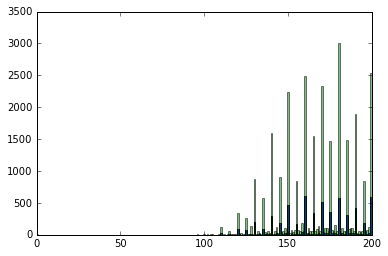

1


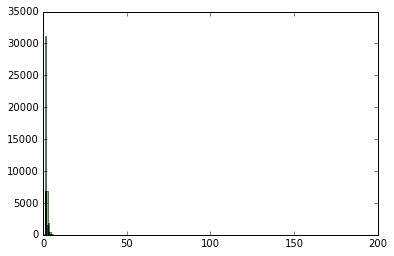

2


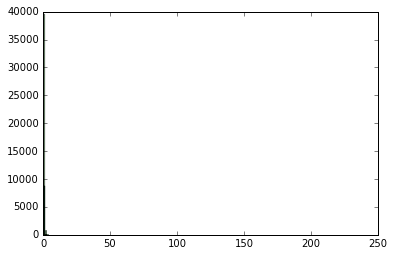

3


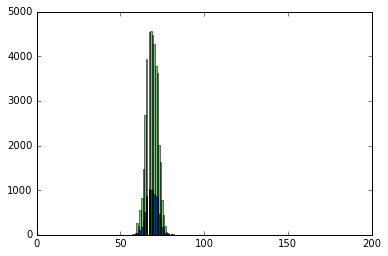

4


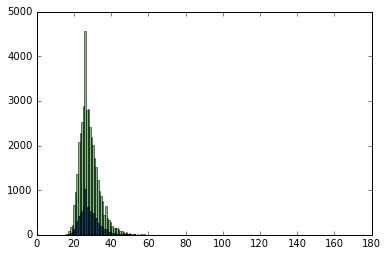

5


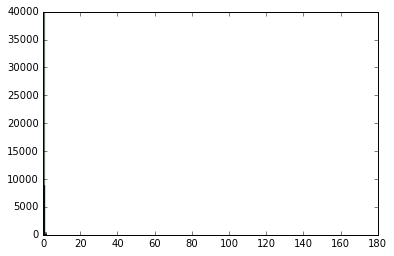

6


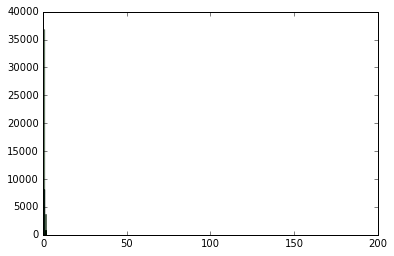

7


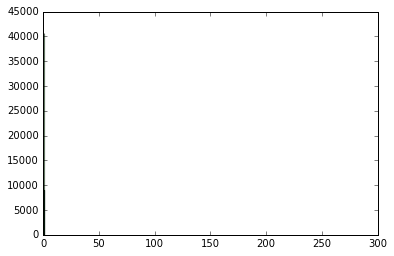

8


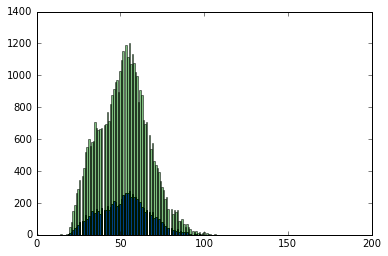

9


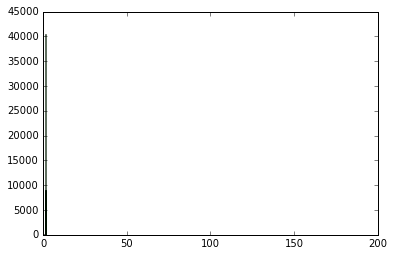

In [18]:
for column in xrange(X_over.shape[1]):
    print column
    plt.figure()
    plt.hist(X_over[y == 1][:, column], bins = np.linspace(0, X_over[column].max(), 200))
    plt.hist(X_over[y == 0][:, column], bins = np.linspace(0, X_over[column].max(), 200), alpha=.5)
    plt.show()

/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


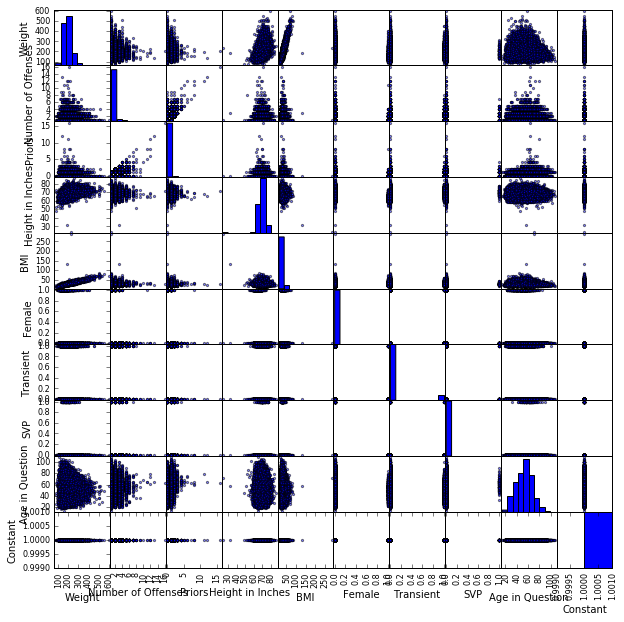

In [19]:
_ = pd.scatter_matrix(attempt, figsize=(10,10))

In [20]:
df.describe()

,Weight,Number of Offenses,Priors,Height in Inches,BMI,Female,Violation,Transient,Age,Years in Violation,SVP,Age in Question,Minimum Sentence,Maximum Sentence
count,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.000000,49446.00000,49446.000000,49446.000000
mean,191.628443,1.329936,0.237572,69.100049,28.823257,0.015148,0.180904,0.090361,54.065668,1.121648,0.002063,52.94402,2.183503,8.056274
std,42.354603,0.704168,0.507049,3.266100,5.784515,0.122142,0.384943,0.286701,14.115505,3.886298,0.045372,14.08658,1.920774,4.993304
min,75.000000,1.000000,0.000000,24.000000,10.416667,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,14.00000,0.000000,0.000000
25%,162.000000,1.000000,0.000000,67.000000,24.979592,0.000000,0.000000,0.000000,45.000000,0.000000,0.000000,43.00000,1.000000,6.000000
50%,185.000000,1.000000,0.000000,69.000000,27.977316,0.000000,0.000000,0.000000,54.000000,0.000000,0.000000,54.00000,3.000000,8.000000
75%,212.000000,1.000000,0.000000,71.000000,31.555880,0.000000,0.000000,0.000000,63.000000,0.000000,0.000000,62.00000,3.000000,10.000000
max,600.000000,16.000000,16.000000,86.000000,287.500000,1.000000,1.000000,1.000000,110.000000,60.000000,1.000000,108.00000,80.000000,80.000000


In [21]:
# drop people under 4 foot, 18610285Y2461, (19711109Z2833? weight?)

In [22]:
# These people could possibly be dead.  Some of them would be over 100 years old.
df[df['Age'] != df['Age in Question']][df['Age'] > 75]['Age'].count()

/Users/DannyPrikaz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


1048

In [23]:
df['Tool Name'].unique()

array(['no info', 'STATIC 99', 'STATIC 99R', 'LOW RISK',
       'LOW-MODERATE RISK', 'HIGH RISK', 'MODERATE-HIGH RISK'], dtype=object)

In [24]:
df['Score'].unique()

array(['no info', '0', '1', '-1', '2', '3', '6', '4', '2 (INCOMPLETE)',
       '7', '5 (INCOMPLETE)', '5', '9', '-2', '-3', '8', '4 (INCOMPLETE)',
       '3 (INCOMPLETE)', '8 (INCOMPLETE)', '7 (INCOMPLETE)',
       '1 (INCOMPLETE)', '(INCOMPLETE)', '6 (INCOMPLETE)', '10',
       '-1 (INCOMPLETE)', '-2 (INCOMPLETE)', '0 (INCOMPLETE)',
       '-3 (INCOMPLETE)', '11', '9 (INCOMPLETE)'], dtype=object)

In [61]:
df['Score'].apply(score_finder).value_counts()

-10    38531
 2      1942
 1      1813
 3      1714
 0      1406
 4      1314
-1       829
 5       739
 6       412
-3       232
-2       210
 7       200
 8        72
 9        25
 10        6
 11        1
Name: Score, dtype: int64

In [65]:
df['Num Score'] = df['Score'].apply(score_finder)
print df['Num Score'].head()
df['Score missing'] = df['Num Score'].apply(lambda x: 1 if x == -10 else 0)
df['Num Score'] = df['Num Score'].apply(lambda x: 2 if x == -10 else x)

0   -10
1   -10
2   -10
3   -10
4   -10
Name: Num Score, dtype: int64


In [60]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def score_finder(string):
    score = string.split(' (INCOMPLETE)')[0]
    if is_number(score):
        return int(score)
    else:
        return -10

In [25]:
print 'No SVP: \n', (df[df['SVP'] == 0]['Violation'] == 1).sum() * 1.0 / (df['SVP'] == 0).sum()
print 'SVP: \n', (df[df['SVP'] == 1]['Violation'] == 1).sum() * 1.0 / (df['SVP'] == 1).sum()
print '\nNo Transient: \n', (df[df['Transient'] == 0]['Violation'] == 1).sum() * 1.0 / (df['Transient'] == 0).sum()
print 'Transient: \n', (df[df['Transient'] == 1]['Violation'] == 1).sum() * 1.0 / (df['Transient'] == 1).sum()

No SVP: 
0.181055447471
SVP: 
0.107843137255

No Transient: 
0.177553470586
Transient: 
0.214637421665


In [26]:
races = list(df['Ethnicity'].unique())
races.remove('OTHER')
df[races] = pd.get_dummies(df['Ethnicity'])[races]

In [27]:
df['Description'].apply(lambda x: sum(1 if 'PANDERING' in y or 'PIMP' in y or 'PROCUREMENT' in y or 'TRAFFICKING' in y else 0 for y in x)).sum()

141

In [28]:
descrip_tags = {}
with open('../data/Words_for_Dummies.txt') as f:
    for line in f:
        if 'skip' in line:
            continue
        key = line.split(':')[0]
        values = line.split(':')[1].split(',')
        values = [val.strip() for val in values]
        descrip_tags[key] = values

In [29]:
len(descrip_tags)

30

In [30]:
for key, value in descrip_tags.iteritems():
    df[key] = df['Description'].apply(lambda x: check_dummy(x, value))

NameError: global name 'check_dummy' is not defined

In [ ]:
def check_dummy(lst, dummy_values):
    tot = 0
    for val in dummy_values:
        for descrip in lst:
            if val in descrip:
                tot += 1
                
    return tot

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
for key, value in descrip_tags.iteritems():
    print key
    print df[key].sum()

In [ ]:
df['Description'][0]

In [32]:
df['redtext2'].value_counts()

DOJ is unable to determine if there are any subsequent felony convictions for this registrant at this time.    41786
Registrant has no California subsequent felony convictions.                                                     3322
Registrant has subsequent felony conviction(s) but DOJ has no incarceration information for this felony.        2970
Registrant was incarcerated for a subsequent felony conviction(s).                                              1368
Name: redtext2, dtype: int64

In [49]:
df['County'] = df['Last Known Address']\
               .apply(lambda x: x.split('County: ')[-1]
                      if (len(x.split('County: ')) > 1) 
                      else 'None')

In [51]:
pd.get_dummies(df['County']).head()

,ALAMEDA,ALPINE,AMADOR,BUTTE,CALAVERAS,COLUSA,CONTRA COSTA,DEL NORTE,EL DORADO,FRESNO,...,SONOMA,STANISLAUS,SUTTER,TEHAMA,TRINITY,TULARE,TUOLUMNE,VENTURA,YOLO,YUBA
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
